In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogFormatter
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 18
from scipy.optimize import minimize
from lteanalysis import LTEAnalysis
import pandas as pd
from scipy.optimize import Bounds
import matplotlib.cm as cm

In [2]:
%matplotlib widget

ModuleNotFoundError: No module named 'ipympl'

In [3]:
# ----- input -----
# for LTE calculation
line  = 'c18o'
Xconv = 1e-7
delv  = 2.0 # km/s
ilines = [3,2] # Ju
Ncols = np.array([5.e16, 5.9e16, 5.e17]) # cm^-2  
Texes = np.array([5, 18, 22, 30]) # K

In [4]:
def cost_function(params, X, Y, model):

    # print("printing params", params)
    N, T = params[0]*1e19, params[1]*50
    X_predicted = model.get_intensity(line = line, Ju = ilines[0], Ncol = N, Tex = T, delv = delv, Xconv = Xconv)
    Y_predicted = model.get_intensity(line = line, Ju = ilines[1], Ncol = N, Tex = T, delv = delv, Xconv = Xconv)
    error = np.sum((X_predicted - X)**2 + (Y_predicted - Y)**2)

    return error

In [5]:
# Initiate Model

lte_model = LTEAnalysis()
lte_model.read_lamda_moldata(line)

## Estimate temperatures on blueshifted side

### Read data

In [6]:

df_blue = pd.read_csv(filepath_or_buffer='Tb_dict_blueshifted_side.csv', sep=',', header='infer')


### Optimizer

In [7]:
# Get T_exe and N_col for all points

T_exe_on_pix = []
N_col_on_pix = []
optimization_flag_on_pix = []
c_sqr = []

initial_params = [1.e15/1.e19, 30./50.]         # N, T guess

bounds = Bounds([1e-5, 0.], [1, 2.0])

for i in range(len(df_blue)):

    # print("Estimating T at R = ", df_blue["R_arcsec"][i])

    print(i)

    result = minimize(cost_function, initial_params, args=(df_blue["Tb_on_pix_b7"][i], df_blue["Tb_on_pix_b6"][i], lte_model),
                        method='Nelder-Mead', bounds = bounds, options={'xatol': 1e-12, 'maxiter' : 10000})

    print('Optimization successful: ', result.success)
    if not result.success:
        print("Estimating T at R = ", df_blue["R_arcsec"][i])
        print('Optimization successful?: ', result.success)
        print("Cause - ", result.message)

    N_col_on_pix.append(float(result.x[0])*1.e19)
    T_exe_on_pix.append(float(result.x[1])*50.)
    optimization_flag_on_pix.append(result.success)
    c_sqr.append(result.fun)

df_blue.loc[:,"N_col_on_pix"] = np.array(N_col_on_pix)
df_blue.loc[:,"T_exe_on_pix"] = np.array(T_exe_on_pix)
df_blue.loc[:,"optimization_flag_on_pix"] = np.array(optimization_flag_on_pix)

print(c_sqr)
print(np.shape(c_sqr))


0


e:\Mihir_new\ASIAA-SSP\LTEAnalysis\lteanalysis\_lteanalysis.py:489: RuntimeWarning: invalid value encountered in double_scalars
  Zarray = np.array([gJ[j]*np.exp(-EJ[j]/Tex) for j in range(len(J))])
e:\Mihir_new\ASIAA-SSP\LTEAnalysis\lteanalysis\_lteanalysis.py:489: RuntimeWarning: divide by zero encountered in double_scalars
  Zarray = np.array([gJ[j]*np.exp(-EJ[j]/Tex) for j in range(len(J))])
e:\Mihir_new\ASIAA-SSP\LTEAnalysis\lteanalysis\_lteanalysis.py:161: RuntimeWarning: divide by zero encountered in double_scalars
  tau_v = (clight*clight*clight)/(8.*np.pi*freq_ul*freq_ul*freq_ul)*(gu/Qrot)*np.exp(-EJu/Tex)*Ncol*Aul*(np.exp(hp*freq_ul/(kb*Tex)) - 1.)/delv
e:\Mihir_new\ASIAA-SSP\LTEAnalysis\lteanalysis\_lteanalysis.py:503: RuntimeWarning: divide by zero encountered in double_scalars
  exp   = np.exp((hp*v)/(kb*T))-1.0


Optimization successful:  True
1
Optimization successful:  True
2
Optimization successful:  True
3
Optimization successful:  True
4
Optimization successful:  True
5
Optimization successful:  True
6
Optimization successful:  True
7
Optimization successful:  True
8
Optimization successful:  True
9
Optimization successful:  True
10
Optimization successful:  True
11
Optimization successful:  True
12
Optimization successful:  True
13
Optimization successful:  True
14
Optimization successful:  True
15
Optimization successful:  True
16
Optimization successful:  True
17
Optimization successful:  True
18
Optimization successful:  True
19
Optimization successful:  True
20
Optimization successful:  True
21
Optimization successful:  True
22
Optimization successful:  True
23
Optimization successful:  True
24
Optimization successful:  True
25
Optimization successful:  True
[1.5146335470154916e-24, 1.2865695205811183e-25, 1.0659285766572617e-26, 9.203245750760934e-27, 6.465565608949633e-25, 6.5797093

### Plotter

In [8]:
df_blue_on_pix = df_blue.drop(df_blue[df_blue['optimization_flag_on_pix'] == False].index).reset_index(drop=True)

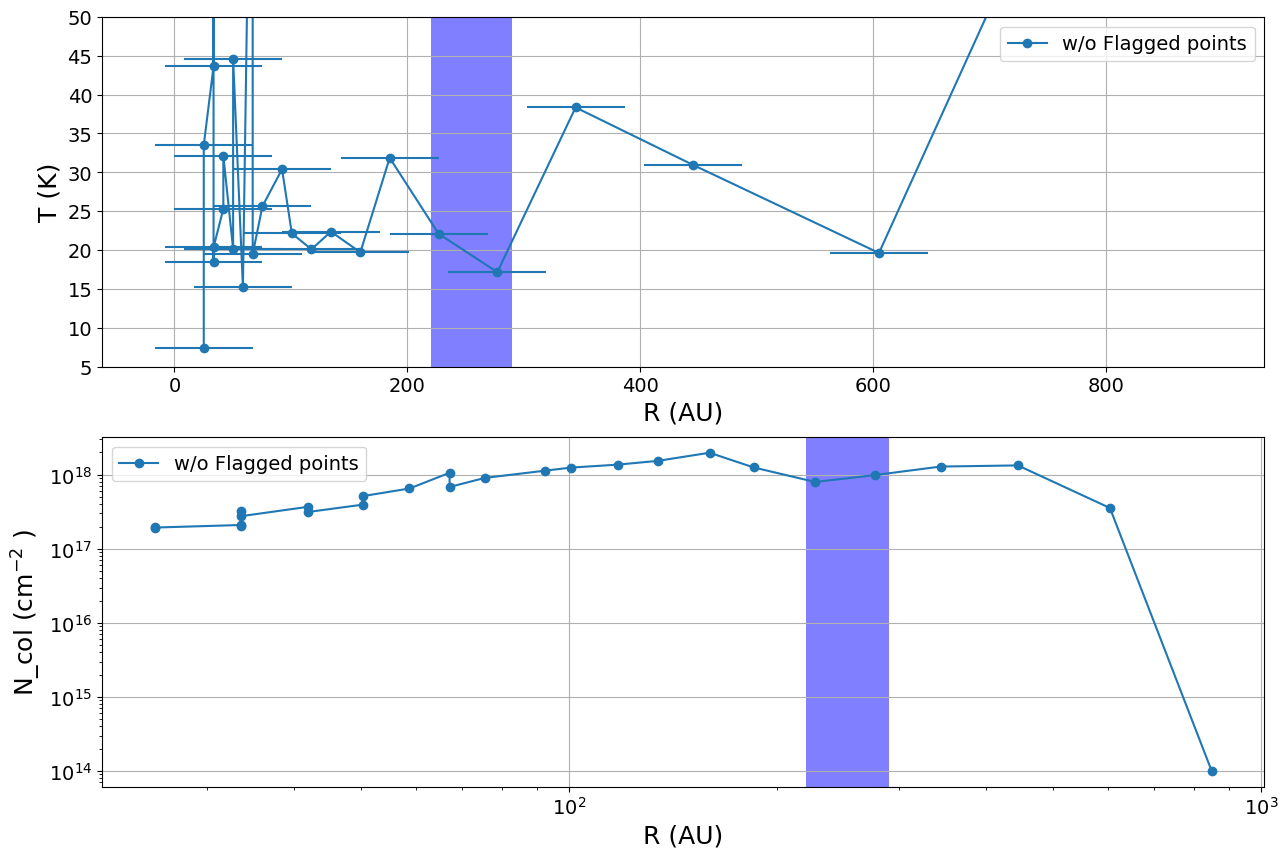

In [9]:

fig, axes = plt.subplots(2,1,figsize=(15, 10))
axes[0].errorbar(-df_blue_on_pix["R_arcsec"]*140., df_blue_on_pix["T_exe_on_pix"], xerr=42., marker='o', label = 'w/o Flagged points')
#axes[0].plot(-df_blue["R_arcsec"]*140., df_blue["T_exe_on_pix"], marker='o', label = 'with Flagged points', c='r')

formatter = LogFormatter(labelOnlyBase=False, minor_thresholds=(np.inf, np.inf))
axes[0].axvspan(xmin = 220, xmax=290, facecolor='b', alpha=0.5)
axes[0].get_xaxis().set_minor_formatter(formatter)
#axes[0].set_xlim(10, 800)
axes[0].set_ylim(5,50)
axes[0].set_ylabel(r"T (K)")
axes[0].set_xlabel("R (AU)")
#axes[0].set_xscale('log')
axes[0].grid(True)
axes[0].legend()


# Plot column density
axes[1].plot(-df_blue_on_pix["R_arcsec"]*140., df_blue_on_pix["N_col_on_pix"], marker='o', label = 'w/o Flagged points')
#axes[1].plot(-df_blue["R_arcsec"]*140., df_blue["N_col_on_pix"]*Xconv, marker='o', label = 'with Flagged points')

formatter = LogFormatter(labelOnlyBase=False, minor_thresholds=(np.inf, np.inf))
axes[1].axvspan(xmin = 220, xmax=290, facecolor='b', alpha=0.5)
axes[1].get_xaxis().set_minor_formatter(formatter)
#axes.set_xlim(10, 800)
#axes.set_ylim(5,50)
axes[1].set_ylabel(r"N_col (cm$^{-2}$ )")
axes[1].set_xlabel("R (AU)")
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].grid(True)
axes[1].legend()


plt.show()

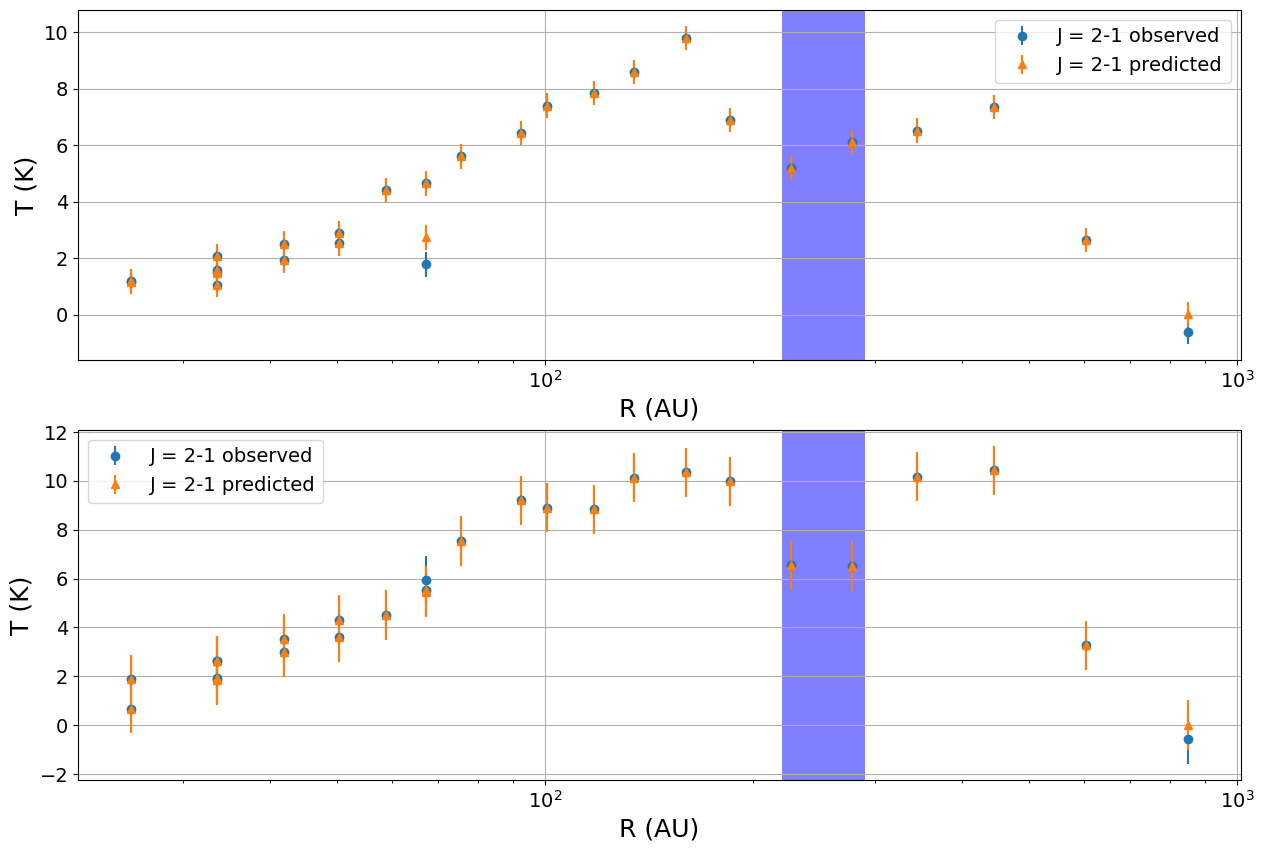

In [17]:
Tb_7_pred_sp_normal_bs = []
Tb_6_pred_sp_normal_bs = []

for i in range(len(df_blue_on_pix["R_arcsec"])):

    Tb_7_pred_sp_normal_bs.append(lte_model.get_intensity(line = line, Ju = ilines[0], Ncol = df_blue_on_pix["N_col_on_pix"][i], Tex = df_blue_on_pix["T_exe_on_pix"][i], delv = 0.5, Xconv=Xconv))
    Tb_6_pred_sp_normal_bs.append(lte_model.get_intensity(line = line, Ju = ilines[1], Ncol = df_blue_on_pix["N_col_on_pix"][i], Tex = df_blue_on_pix["T_exe_on_pix"][i], delv = 0.5, Xconv=Xconv))

fig, axes = plt.subplots(2,1,figsize=(15, 10))
axes[0].errorbar(-df_blue_on_pix["R_arcsec"]*140., df_blue_on_pix["Tb_on_pix_b6"], yerr=0.43, marker='o', ls='none', label = 'J = 2-1 observed')
axes[0].errorbar(-df_blue_on_pix["R_arcsec"]*140., Tb_6_pred_sp_normal_bs, yerr=0.43, marker='^', ls='none', label = 'J = 2-1 predicted')
#axes[0].plot(-df_blue["R_arcsec"]*140., df_blue["T_exe_on_pix"], marker='o', label = 'with Flagged points', c='r')

formatter = LogFormatter(labelOnlyBase=False, minor_thresholds=(np.inf, np.inf))
axes[0].axvspan(xmin = 220, xmax=290, facecolor='b', alpha=0.5)
axes[0].get_xaxis().set_minor_formatter(formatter)
#axes[0].set_xlim(10, 800)
#axes[0].set_ylim(5,50)
axes[0].set_ylabel(r"T (K)")
axes[0].set_xlabel("R (AU)")
axes[0].set_xscale('log')
axes[0].grid(True)
axes[0].legend()


axes[1].errorbar(-df_blue_on_pix["R_arcsec"]*140., df_blue_on_pix["Tb_on_pix_b7"], yerr=1.01, marker='o', ls='none', label = 'J = 2-1 observed')
axes[1].errorbar(-df_blue_on_pix["R_arcsec"]*140., Tb_7_pred_sp_normal_bs, yerr=1.01, marker='^', ls='none', label = 'J = 2-1 predicted')

formatter = LogFormatter(labelOnlyBase=False, minor_thresholds=(np.inf, np.inf))
axes[1].axvspan(xmin = 220, xmax=290, facecolor='b', alpha=0.5)
axes[1].get_xaxis().set_minor_formatter(formatter)
#axes.set_xlim(10, 800)
#axes.set_ylim(5,50)
axes[1].set_ylabel(r"T (K)")
axes[1].set_xlabel("R (AU)")
axes[1].set_xscale('log')
axes[1].grid(True)
axes[1].legend()

plt.show()

####
compare

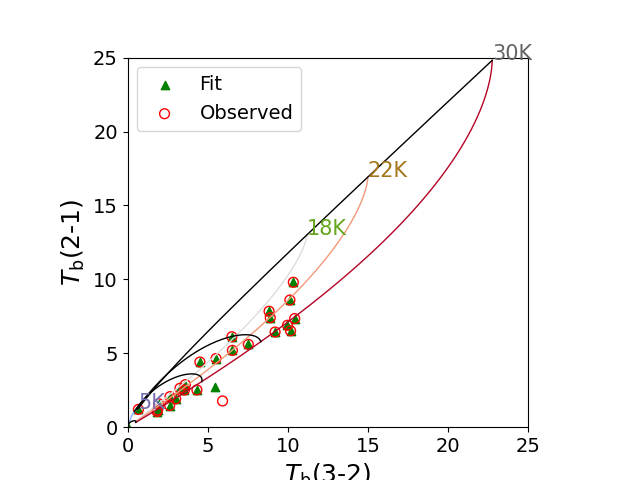

In [24]:

Ncols = np.array([5.e16, 5.e17, 1.e18, 5.e19]) # cm^-2  
Texes = np.array([5, 18, 22, 30]) # K

fig, ax = lte_model.makegrid(line, ilines[0], ilines[1], Texes, Ncols, delv=2.0, Xconv=Xconv, lw=1.)
ax.set_xlim(0., 25)
ax.set_ylim(0., 25)

Tb_7_pred_sp_normal_bs = []
Tb_6_pred_sp_normal_bs = []

for i in range(len(df_blue_on_pix["R_arcsec"])):

    Tb_7_pred_sp_normal_bs.append(lte_model.get_intensity(line = line, Ju = ilines[0], Ncol = df_blue_on_pix["N_col_on_pix"][i], Tex = df_blue_on_pix["T_exe_on_pix"][i], delv = 0.5, Xconv=Xconv))
    Tb_6_pred_sp_normal_bs.append(lte_model.get_intensity(line = line, Ju = ilines[1], Ncol = df_blue_on_pix["N_col_on_pix"][i], Tex = df_blue_on_pix["T_exe_on_pix"][i], delv = 0.5, Xconv=Xconv))

ax.scatter(Tb_7_pred_sp_normal_bs, Tb_6_pred_sp_normal_bs, color = 'green', marker = '^', label = 'Fit')
ax.scatter(df_blue_on_pix["Tb_on_pix_b7"], df_blue_on_pix["Tb_on_pix_b6"], color = 'red', marker = 'o', s=50, facecolors='none', edgecolors='r', label = 'Observed')
plt.legend()
plt.show()

## Estimate temperatures on redshifted side

In [8]:
# Read data

df_red = pd.read_csv(filepath_or_buffer='Tb_dict_redshifted_side.csv', sep=',', header='infer')

# print(df_blue)

In [9]:
# Get T_exe and N_col for all points

T_exe_on_pix = []
N_col_on_pix = []
optimization_flag_on_pix = []

T_exe_max_pix = []
N_col_max_pix = []
optimization_flag_max_pix = []

T_exe_max_pix_fix_r = []
N_col_max_pix_fix_r = []
optimization_flag_max_pix_fix_r = []


initial_params = [1.e15/1.e19, 30./50.]         # N, T guess

for i in range(len(df_red)):

    # print("Estimating T at R = ", df_blue["R_arcsec"][i])

    result_on_pix = minimize(cost_function, initial_params, args=(df_red["Tb_on_pix_b7"][i], df_red["Tb_on_pix_b6"][i], lte_model),
                       method='Nelder-Mead', options={'xatol': 1e-7, 'maxiter' : 10000})
    
    result_max_pix = minimize(cost_function, initial_params, args=(df_red["Tb_max_pix_rs_b7"][i], df_red["Tb_max_pix_rs_b6"][i], lte_model),
                       method='Nelder-Mead', options={'xatol': 1e-7, 'maxiter' : 10000})
        
    result_max_pix_fix_r = minimize(cost_function, initial_params, args=(df_red["Tb_max_pix_b7_rs_fix_r"][i], df_red["Tb_max_pix_b6_rs_fix_r"][i], lte_model),
                       method='Nelder-Mead', options={'xatol': 1e-7, 'maxiter' : 10000})

    # print('Optimization successful: ', result.success)
    if not result_on_pix.success:
        print("Estimating T at R = ", df_red["R_arcsec"][i])
        print("uing on pixel meassurement")
        print('Optimization successful: ', result_on_pix.success)
        print("Cause - ", result_on_pix.message)

    if not result_max_pix.success:
        print("Estimating T at R = ", df_red["R_arcsec"][i])
        print("uing on pixel meassurement")
        print('Optimization successful: ', result_max_pix.success)
        print("Cause - ", result_max_pix.message)

    N_col_on_pix.append(float(result_on_pix.x[0])*1.e19)
    T_exe_on_pix.append(float(result_on_pix.x[1])*50.)
    optimization_flag_on_pix.append(result_on_pix.success)

    N_col_max_pix.append(float(result_max_pix.x[0])*1.e19)
    T_exe_max_pix.append(float(result_max_pix.x[1])*50.)
    optimization_flag_max_pix.append(result_max_pix.success)

    N_col_max_pix_fix_r.append(float(result_max_pix.x[0])*1.e19)
    T_exe_max_pix_fix_r.append(float(result_max_pix.x[1])*50.)
    optimization_flag_max_pix_fix_r.append(result_max_pix.success)

df_red.loc[:,"N_col_on_pix"] = np.array(N_col_on_pix)
df_red.loc[:,"T_exe_on_pix"] = np.array(T_exe_on_pix)
df_red.loc[:,"optimization_flag_on_pix"] = np.array(optimization_flag_on_pix)

df_red.loc[:,"N_col_max_pix"] = np.array(N_col_max_pix)
df_red.loc[:,"T_exe_max_pix"] = np.array(T_exe_max_pix)
df_red.loc[:,"optimization_flag_max_pix"] = np.array(optimization_flag_max_pix)

df_red.loc[:,"N_col_max_pix_fix_r"] = np.array(N_col_max_pix_fix_r)
df_red.loc[:,"T_exe_max_pix_fix_r"] = np.array(T_exe_max_pix_fix_r)
df_red.loc[:,"optimization_flag_max_pix_fix_r"] = np.array(optimization_flag_max_pix_fix_r)


d:\L1489_IRS_ssp\LTEAnalysis\lteanalysis\_lteanalysis.py:483: RuntimeWarning: overflow encountered in exp
  Zarray = np.array([gJ[j]*np.exp(-EJ[j]/Tex) for j in range(len(J))])


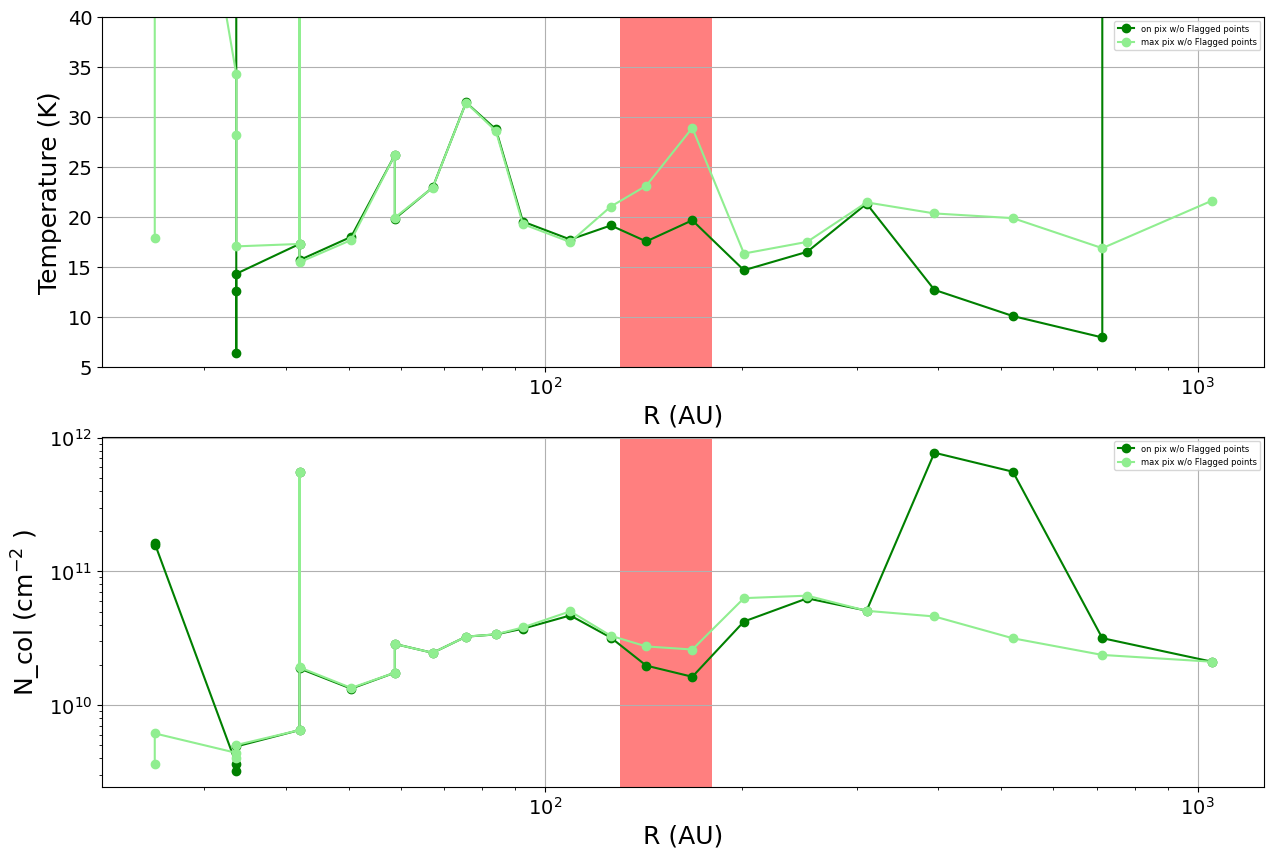

In [60]:
df_red_on_pix = df_red.drop(df_red[df_red['optimization_flag_on_pix'] == False].index)

df_red_max_pix = df_red.drop(df_red[df_red['optimization_flag_max_pix'] == False].index)

df_red_max_pix_fix_r = df_red.drop(df_red[df_red['optimization_flag_max_pix_fix_r'] == False].index)

fig, axes = plt.subplots(2,1, figsize = (15,10))

axes[0].plot(df_red_on_pix["R_arcsec"]*140., df_red_on_pix["T_exe_on_pix"], marker='o', label = 'on pix w/o Flagged points', color = 'green')
#axes[0].plot(df_red["R_arcsec"]*140., df_red["T_exe_on_pix"], marker='o', label = 'on pix with Flagged points', color = 'lightgreen')

axes[0].plot(df_red_max_pix["R_arcsec"]*140., df_red_max_pix["T_exe_max_pix"], marker='o', label = 'max pix w/o Flagged points', color = 'lightgreen')
#axes[0].plot(df_red["R_arcsec"]*140., df_red["T_exe_max_pix"], marker='o', label = 'max pix with Flagged points', color = 'orchid')

# axes.plot(df_red_max_pix_fix_r["R_arcsec"]*140., df_red_max_pix_fix_r["T_exe_max_pix_fix_r"], marker='o', label = 'max pix fR w/o Flagged points', color = 'aquamarine')
# axes.plot(df_red["R_arcsec"]*140., df_red["T_exe_max_pix_fix_r"], marker='o', label = 'max pix fR with Flagged points', color = 'aqua')


formatter = LogFormatter(labelOnlyBase=False, minor_thresholds=(np.inf, np.inf))
axes[0].set_ylabel("Temperature (K)")
axes[0].set_xlabel("R (AU)")
axes[0].axvspan(xmin = 130, xmax=180, facecolor='r', alpha=0.5)
axes[0].get_xaxis().set_minor_formatter(formatter)
#axes[0].set_xlim(10, 1200)
axes[0].set_ylim(5,40)
axes[0].set_xscale('log')
axes[0].grid(True)
axes[0].legend(prop={'size': 6})


### Plot Ncol vs R

axes[1].plot(df_red_on_pix["R_arcsec"]*140., df_red_on_pix["N_col_on_pix"]*Xconv, marker='o', label = 'on pix w/o Flagged points', color = 'green')
#axes[1].plot(df_red["R_arcsec"]*140., df_red["N_col_on_pix"]*Xconv, marker='o', label = 'on pix with Flagged points', color = 'lightgreen')

axes[1].plot(df_red_max_pix["R_arcsec"]*140., df_red_max_pix["N_col_max_pix"]*Xconv, marker='o', label = 'max pix w/o Flagged points', color = 'lightgreen')
#axes[1].plot(df_red["R_arcsec"]*140., df_red["N_col_max_pix"]*Xconv, marker='o', label = 'max pix with Flagged points', color = 'orchid')

# axes.plot(df_red_max_pix_fix_r["R_arcsec"]*140., df_red_max_pix_fix_r["T_exe_max_pix_fix_r"], marker='o', label = 'max pix fR w/o Flagged points', color = 'aquamarine')
# axes.plot(df_red["R_arcsec"]*140., df_red["T_exe_max_pix_fix_r"], marker='o', label = 'max pix fR with Flagged points', color = 'aqua')


formatter = LogFormatter(labelOnlyBase=False, minor_thresholds=(np.inf, np.inf))
axes[1].axvspan(xmin = 130, xmax=180, facecolor='r', alpha=0.5)
axes[1].set_ylabel(r"N_col (cm$^{-2}$ )")
axes[1].set_xlabel("R (AU)")
axes[1].get_xaxis().set_minor_formatter(formatter)
#axes.set_xlim(10, 1200)
#axes.set_ylim(5,40)
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].grid(True)
axes[1].legend(prop={'size': 6})

plt.show()

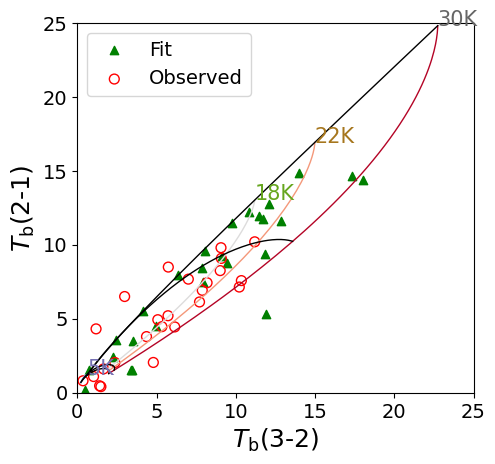

In [66]:

Ncols = np.array([5.e16, 5.9e16, 5.e17, 5.e19]) # cm^-2  
Texes = np.array([5, 18, 22, 30]) # K

fig, ax = lte_model.makegrid(line, ilines[0], ilines[1], Texes, Ncols, delv, Xconv=Xconv, lw=1.)
ax.set_xlim(0., 25)
ax.set_ylim(0., 25)

Tb_7_pred_sp_normal_bs = []
Tb_6_pred_gd_normal_bs = []


for i in range(len(df_red_on_pix["R_arcsec"])):
    Tb_7_pred_sp_normal_bs.append(lte_model.get_intensity(line = line, Ju = ilines[0], Ncol = df_red_on_pix["N_col_on_pix"][i], Tex = df_red_on_pix["T_exe_on_pix"][i], delv = 0.2, Xconv=Xconv))
    Tb_6_pred_gd_normal_bs.append(lte_model.get_intensity(line = line, Ju = ilines[1], Ncol = df_red_on_pix["N_col_on_pix"][i], Tex = df_red_on_pix["T_exe_on_pix"][i], delv = 0.2, Xconv=Xconv))


ax.scatter(Tb_7_pred_sp_normal_bs, Tb_6_pred_gd_normal_bs, color = 'green', marker = '^', label = 'Fit')
ax.scatter(df_red_on_pix["Tb_on_pix_b7"], df_red_on_pix["Tb_on_pix_b6"], color = 'red', marker = 'o', s=50, facecolors='none', edgecolors='r', label = 'Observed')
plt.legend()
plt.show()